# Time Analysis


You can create a simple time analysis of a classified trajectory by using the [transition submodue](generated/SOAPify.transitions.rst#module-SOAPify.transitions)

The time analysis works with the concepts of _windows_ and _stride_.

The _window_ is the number of frame between wich the state of an atom is confronted, the more is higher the _window_ the more time passes between the two states:
![](images/timeAnalysisWindows.png)

The _stride_  is how many frames the window with the confronatation is displaced during the analysis. A _stride_ must be alwayis inferior or equal to the value of the _window_:
![](images/timeAnalysisStrides.png)

If you want to analyze the trajectory as if it has been sampled at a slower rate simply use the same number for _window_ and _stride_:
![](images/timeAnalysisStridesEqualWindow.png)

## Random example
In the following example we will show a simple time analysis of a random trajectory of three states (should result in a 'plain' transition matrix).

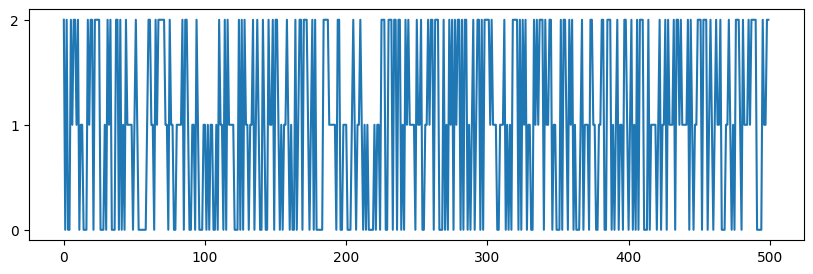

In [1]:
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
import SOAPify.transitions as st
from SOAPify import SOAPclassification
import seaborn as sns
rng = npr.default_rng(12345)
cls=SOAPclassification(
    [],
    rng.integers(0, 3, size=(500,1)),
    [0,1,2]
    )
_,ax=plt.subplots(figsize=(10,3))
ax.set_yticks([0,1,2])
_ =ax.plot(cls.references[:,0])

<AxesSubplot: >

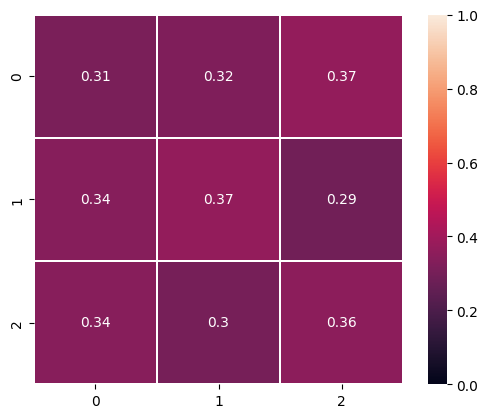

In [2]:
tmat = st.calculateTransitionMatrix(cls)
tmat= st.normalizeMatrix(tmat)
sns.heatmap(tmat, annot=True,linewidths=0.1,square=True,vmax=1, vmin=0)

## Example: 4 states, markov chain

A simple 1 atom system with 4 states and possibility to evolve only to adiacent states

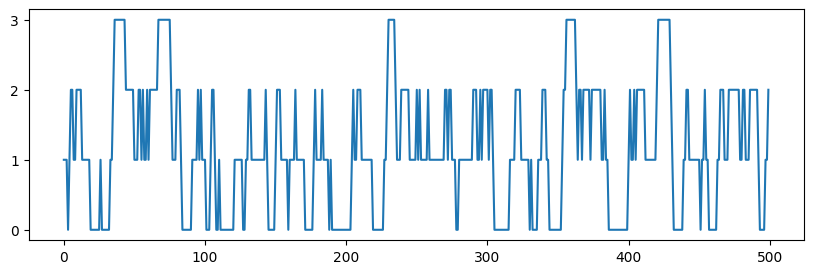

In [3]:
rng = npr.default_rng(123456)
P=np.array([
    [0.8,0.2,0.0,0.0],
    [0.1,0.7,0.2,0.0],
    [0.0,0.3,0.6,0.1],
    [0.0,0.0,0.2,0.8],
            ])
#contstuct a target table:
target=P
for j in range(1,4):
    target[:,j]+=target[:,j-1]


cls=np.empty((500,1),dtype=int)
cls[0,0]=1
for i,c in enumerate(cls[:-1,0]):
    t=rng.random()
    cls[i+1,0]= np.argwhere(target[c]>t)[0]
cls=SOAPclassification(
    [],
    cls,
    [0,1,2,3]
    )
_,ax=plt.subplots(figsize=(10,3))
ax.set_yticks([0,1,2,3])
_ =ax.plot(cls.references[:,0])

The transition matrices calculated changing the window value and the stride value

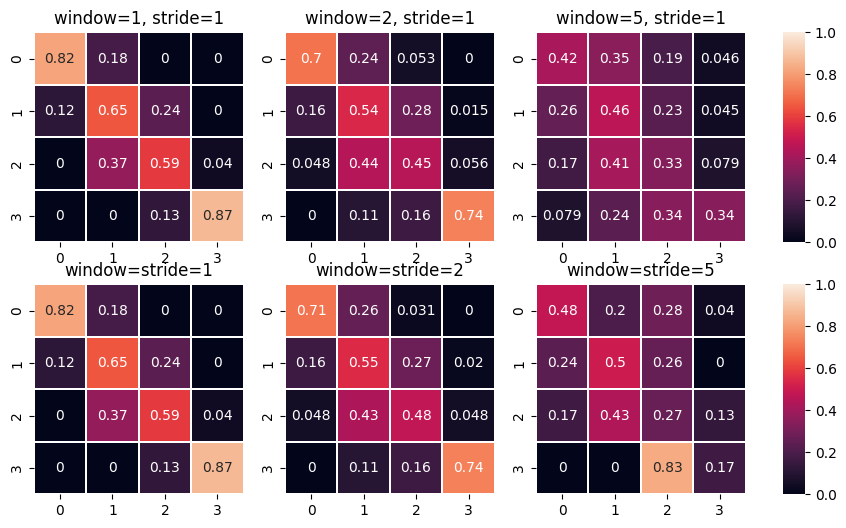

In [4]:
_,ax=plt.subplots(2,4,figsize=(10,6), gridspec_kw={'width_ratios':[1,1,1,0.1]})
for i, window in enumerate([1,2,5]):
    tmat = st.calculateTransitionMatrix(cls, window=window, stride=1)
    tmat= st.normalizeMatrix(tmat)
    sns.heatmap(tmat, annot=True,linewidths=0.1,
                square=True,vmax=1, vmin=0, ax = ax[0,i],
                cbar=i != 1,
                cbar_ax= ax[0,3] if i!=1  else None)
    ax[0,i].set_title(f"window={window}, stride=1")
for i, window in enumerate([1,2,5]):
    tmat = st.calculateTransitionMatrix(cls, window=window, stride=window)
    tmat= st.normalizeMatrix(tmat)
    sns.heatmap(tmat, annot=True,linewidths=0.1,
                square=True,vmax=1, vmin=0, ax = ax[1,i],
                cbar=i != 1,
                cbar_ax= ax[1,3] if i!=1  else None)
    ax[1,i].set_title(f"window=stride={window}")

How to calculate and show the events, the algorithm will set the first and last residence time with a negative time, to suggest that these event are not correctly sampled

In [ ]:
residenceTimes = st.calculateResidenceTimes(
        cl, stride=1, window=1
    )